# Import libraries

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer


# Fetch and split the titanic dataset

In [122]:

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create pre-processing and training pipelines

In [123]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42, oob_score=True)),
    ]
)
rf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


# Assess the accuracy of the model

In [124]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")
print(f"RF out-of-bag accuracy: {rf[-1].oob_score_:.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814
RF out-of-bag accuracy: 0.779


# Plot the MDI feature importance of the overfitted random forest, with features of variable cardinality.

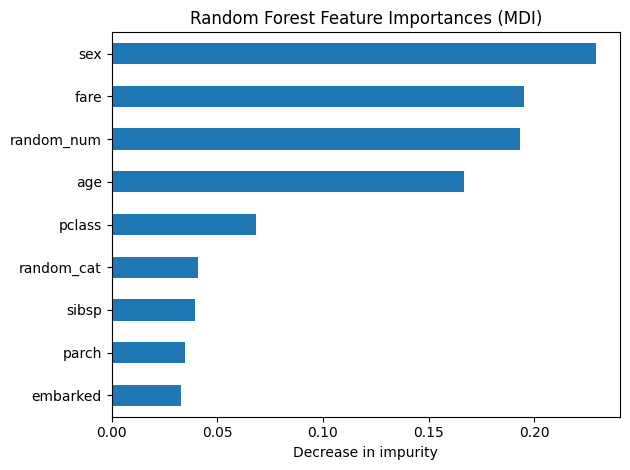

In [125]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.set_xlabel("Decrease in impurity")
ax.figure.tight_layout()

# Bin the high cardinality features and grid search the best number of bins and the hyper paprameters of rf

In [126]:
high_card_columns = X.columns[X.nunique()>10].tolist()
low_card_columns = X.columns[X.nunique()<=10].tolist()

preprocessing.set_output(transform="pandas")

discretizer = KBinsDiscretizer(encode="ordinal", strategy="uniform", random_state=42)
binner = ColumnTransformer(
    [
        ("high_card", discretizer, high_card_columns),
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

rf_binned = Pipeline(
    [
        ("preprocess", preprocessing),
        ("bin", binner),
        ("classifier", RandomForestClassifier(random_state=42, oob_score=True)),
    ]
)

param_grid = {
    "bin__high_card__n_bins": list(range(2, 11)),
    "classifier__min_samples_leaf": [1, 2, 4, 6, 8, 10, 15, 20, 25, 50, 100],
}

gs = GridSearchCV(estimator=rf_binned, param_grid=param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'bin__high_card__n_bins': [2, 3, ...], 'classifier__min_samples_leaf': [1, 2, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


Tuned RF train accuracy: 0.827
Tuned RF test accuracy: 0.841
Tuned RF out-of-bag accuracy: 0.790


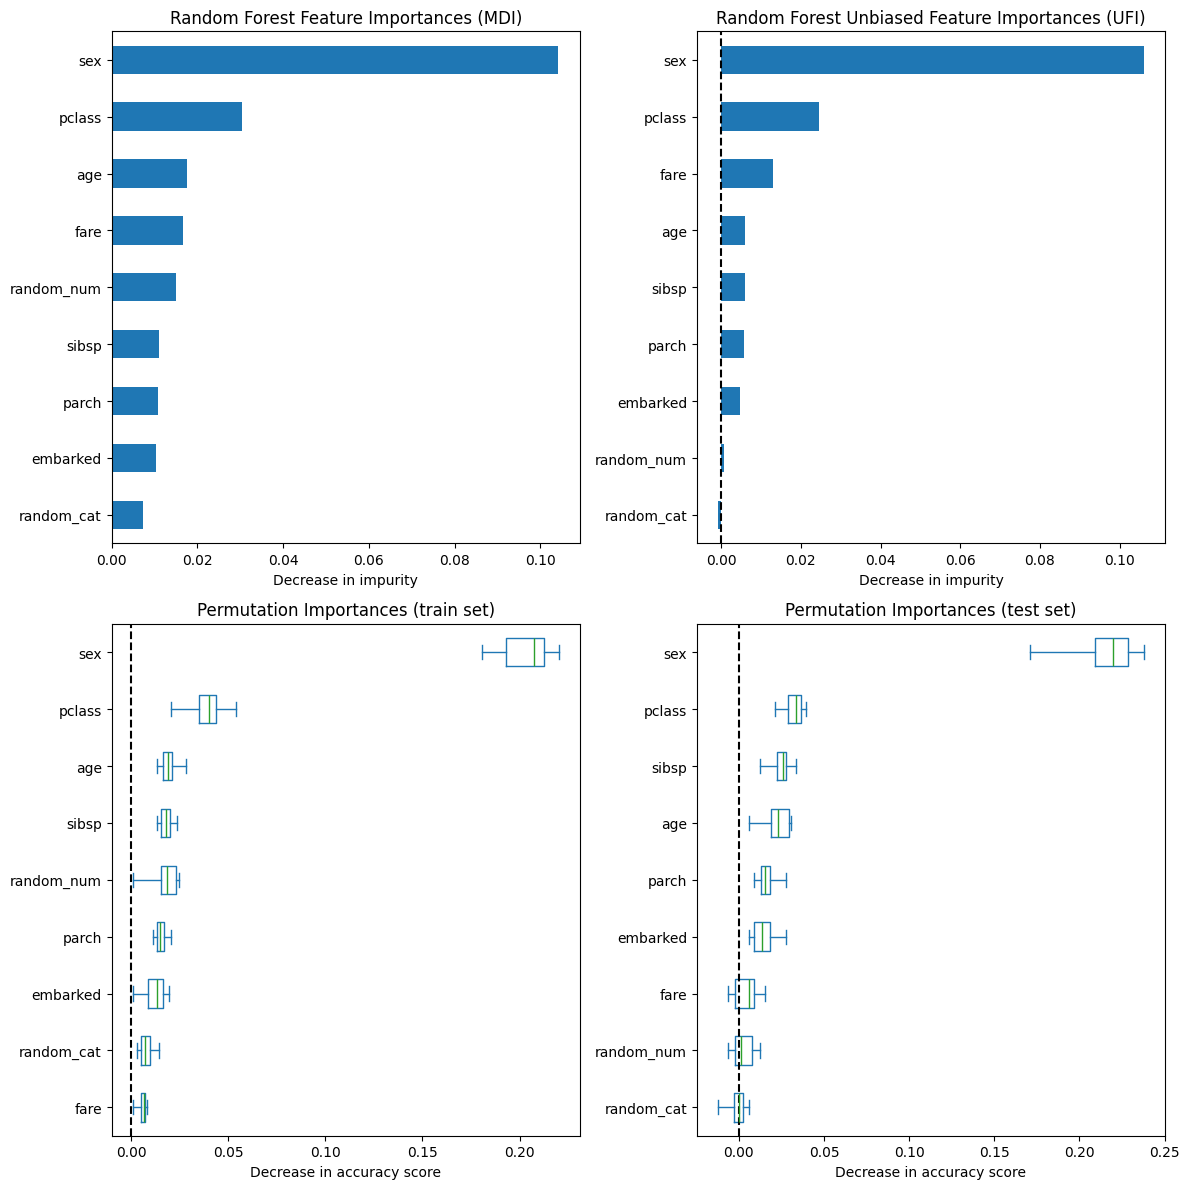

In [134]:
rf_tuned = gs.best_estimator_

print(f"Tuned RF train accuracy: {rf_tuned.score(X_train, y_train):.3f}")
print(f"Tuned RF test accuracy: {rf_tuned.score(X_test, y_test):.3f}")
print(f"Tuned RF out-of-bag accuracy: {rf_tuned[-1].oob_score_:.3f}")
feature_names = rf_tuned[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf_tuned[-1]._unnormalized_feature_importances, index=feature_names
).sort_values(ascending=True)

ufi_importances = pd.Series(
    rf_tuned[-1].unbiased_feature_importances_, index=feature_names
).sort_values(ascending=True)

result_train = permutation_importance(
    rf_tuned, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

result_test = permutation_importance(
    rf_tuned, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax = ax.flatten()
ax[0] = mdi_importances.plot.barh(ax=ax[0])
ax[0].set_xlabel("Decrease in impurity")
ax[0].set_title("Random Forest Feature Importances (MDI)")

ax[1] = ufi_importances.plot.barh(ax=ax[1])
ax[1].set_xlabel("Decrease in impurity")
ax[1].axvline(x=0, color="k", linestyle="--")
ax[1].set_title("Random Forest Unbiased Feature Importances (UFI)")

importances_train.plot.box(vert=False, whis=10, ax=ax[2])
ax[2].set_title("Permutation Importances (train set)")
ax[2].axvline(x=0, color="k", linestyle="--")
ax[2].set_xlabel("Decrease in accuracy score")

importances_test.plot.box(vert=False, whis=10, ax=ax[3])
ax[3].set_title("Permutation Importances (test set)")
ax[3].axvline(x=0, color="k", linestyle="--")
ax[3].set_xlabel("Decrease in accuracy score")

fig.tight_layout()